# Data Science Smörgåsbord: Classification
### Kori Thompson
Please note this is an exercise to familarlize yourself with different classification algorithms and to understand how to interpret the models. Actual data science project typically use more complex dataset, involve more in-depth exploratory data analysis and use more best pratices than this exercise.

Classification algorithms are supervised machine learning algorithms that attempt to predict which class of a categorical variable an instance belongs to. For example, a classification algorithm might seek to identify whether a person is likely to buy a product given a set of input features. These models are typically assessed using confusion matrices and its corresponsing metrics (recall, precision, accuracy) as well as ROC-AUC scores. This exercise examines three different classification algorithms and walks through how to interpret the confusion matrices and ROC-AUC scores. It also highlights the effects of scaling data for distance based algorithms.

In [1]:
# data manipulation
import numpy as np
import pandas as pd
# data visualization
from matplotlib import pyplot as plt 
import seaborn as sns
# utilities
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler
# modeling and metrics
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (classification_report, 
                             confusion_matrix, 
                             ConfusionMatrixDisplay,
                             accuracy_score, 
                             precision_score, 
                             recall_score,
                             roc_curve,
                             roc_auc_score)

## Exploratory Data Analysis

In [2]:
df = sns.load_dataset('titanic')

In [8]:
df.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [11]:
df.isnull().sum()/df.isnull().sum().sum()

survived       0.000000
pclass         0.000000
sex            0.000000
age            0.203682
sibsp          0.000000
parch          0.000000
fare           0.000000
embarked       0.002301
class          0.000000
who            0.000000
adult_male     0.000000
deck           0.791715
embark_town    0.002301
alive          0.000000
alone          0.000000
dtype: float64

Since the proportion of null values for the deck feature is above 50%, it makes little sense to try and input values. Since the feature is mostly null, it provides little information for the majority of the dataset, we will drop the feature from the dataset.

In [3]:
df.drop(columns='deck', inplace=True)

In [10]:
df[['pclass','class']].drop_duplicates()

,pclass,class
0,3,Third
1,1,First
9,2,Second


Based on an examination, it is clear that the pclass and the class features are redundant. Therefore one of the features can be removed from the dataset without the loss of any information. This helps to reduce the dimensionality of the dataset and remove any potential colinearity among the features that can obscure the relationship of input features to the target feature.

In [11]:
df[['survived','alive']].drop_duplicates()

,survived,alive
0,0,no
1,1,yes


The survived and alive features are also redundant features and one feature should be removed from the dataset.

In [12]:
df[['embarked','embark_town']].drop_duplicates()

,embarked,embark_town
0,S,Southampton
1,C,Cherbourg
5,Q,Queenstown
61,NaN,NaN


Again, the embarked and embarked_town features are redundant features and one feature should be removed from the dataset.

In [45]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df.groupby(['who','sex'])['adult_male'].value_counts()

who    sex     adult_male
child  female  False          43
       male    False          40
man    male    True          537
woman  female  False         271
Name: count, dtype: int64

Interestingly, the who feature is also a redundant feature as it contains the same information as the sex and adult_male features. As such the feature can also be removed from the dataset as it adds no additional information.

In [4]:
df.drop(columns=['alive','embarked','class','who'],inplace=True)

In [56]:
df.groupby(['adult_male',df['age']>=16, df['age'].isnull()])['sex'].value_counts()

adult_male  age    age    sex   
False       False  False  female     43
                          male       40
                   True   female     53
            True   False  female    218
True        False  True   male      124
            True   False  male      413
Name: count, dtype: int64

The logic to calculate the adult_male column combines both the sex and age features. A passenger sex must be equal to male and their age must be greater than or equal to 16 or the age must be null for adult_male to be true else adult_male is false. Since this feaure is also redundant it can safely be removed from the dataset.

In [5]:
df.drop(columns='adult_male',inplace=True)

In [53]:
df.groupby('sex')['survived'].value_counts()

sex     survived
female  1           233
        0            81
male    0           468
        1           109
Name: count, dtype: int64

In [52]:
df.groupby('sex')['survived'].value_counts().apply(lambda x: x/df['survived'].count())

sex     survived
female  1           0.261504
        0           0.090909
male    0           0.525253
        1           0.122334
Name: count, dtype: float64

An interesting trend in the data and a particularly well know trend is that women were more likely to survive the Titantic than men. In fact approximately 52.5% of men did not survive compared to 0.09% of women that did not survive. Another trend of note, it that there were significantly more men on the Titantic than there were women present.

In [55]:
df.groupby(['pclass'])['survived'].value_counts().apply(lambda x: x/df['pclass'].count())

pclass  survived
1       1           0.152637
        0           0.089787
2       0           0.108866
        1           0.097643
3       0           0.417508
        1           0.133558
Name: count, dtype: float64

Another familiar trend that can be seen in the data, is that fact that those in higher classes tended to survive at higher rates than those in the lower classes. You can also note for the percentages, that there were a larger share of passengers in the lower classes, particularly in third class than there were in other classes.

In [61]:
df['fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: fare, dtype: float64

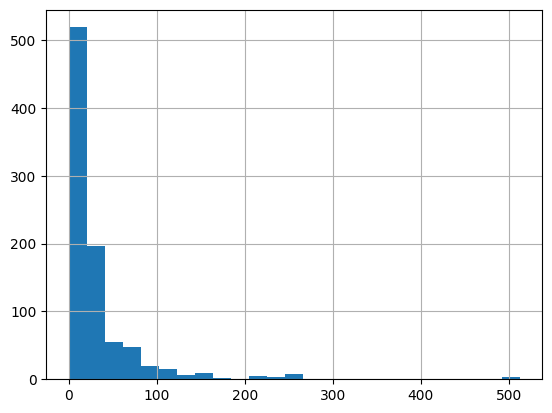

In [ ]:
df['fare'].hist(bins=25, xlabel='Fare', ylabel='Count')
plt.show()

The fare distribution skews right and has a large spread of values. There is has a high number of data points with a fare equal clustered around $0 and one outlier point with a fare of around $500. The most frequent fare price was $14.45, the minimum fare was $0 and the maximum fare was $512.33. 

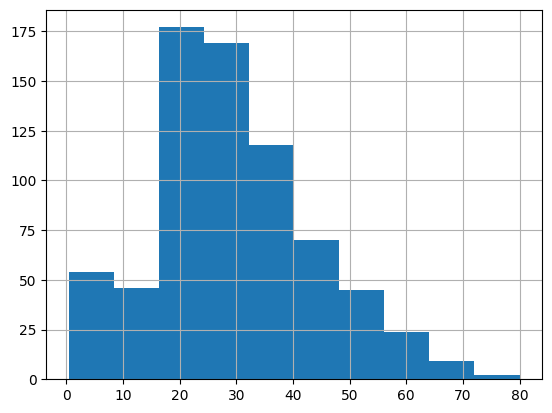

In [ ]:
df['age'].hist(xlabel='Age', ylabel='Count')
plt.show()

In [64]:
df['age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: age, dtype: float64

The distribution of the non-null values of the age feature approximates a normal distribution with a peak at around 20 to 30 years of age. The minmum age was 0.42 years and the maximum age was 80 years. The most frequent age of passengers was 28 years. The distribution also has a relatively small spread of values with a standard deviation of 14.526 compared to the spread of data in the fare distribution. 

In [65]:
df.groupby('pclass')['age'].median()

pclass
1    37.0
2    29.0
3    24.0
Name: age, dtype: float64

The median age of each passenger class differs with the highest median age being in class 1 and the lowest median age in class 3. As such any inputation of values should also take into consideration the class in which the passenger was in.

In [6]:
df['age'] = df.groupby('pclass')['age'].transform(lambda x: x.fillna(value= x.median()))

As the remaining null values are relatively small, less than 1% of the dataset, we will drop the instances with remaining null values.

In [7]:
df.dropna(inplace=True)
df.isnull().sum()

survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embark_town    0
alone          0
dtype: int64

In [17]:
print(f'The number of remaining rows in the dataset: {len(df)}')

The number of remaining rows in the dataset: 889


In [93]:
df.dtypes

survived         int64
pclass           int64
sex             object
age            float64
sibsp            int64
parch            int64
fare           float64
embark_town     object
alone             bool
dtype: object

Of the features in the dataset, pclass, sex, embark_town, and alone are categorical. This can be seen as each value only takes on a specific set of values. For example the pclass feature can only take on either 1, 2, or 3 for a value while both sex and alone are binary. To use these features in our models we will one-hot encode these features so that each value of the feature becomes its own binary feature signifying the presence of that value for the instance.

In [8]:
df_cleaned = pd.get_dummies(df, columns=['pclass','sex','embark_town','alone'])

## Modeling

In [9]:
xTrain, xTest, yTrain, yTest = train_test_split(df_cleaned.drop(columns=['survived']),
                                                df_cleaned.survived, 
                                                random_state= 5280, 
                                                train_size=0.2,
                                                stratify=df_cleaned.survived)

Since the classes for our target feature, survived, are imbalanced we want to preserve this imbalance between the training and test sets. This enables the model to learn the imbalance and then be tested on a similarly imbalanced dataset. Since this is the entire population, we know that the imbalance is reflected in the population which is why we are preserving the imbalance in both the test and training datasets.

In [34]:
print(f'Dimensions \nTraining:{xTrain.shape} \nTesting:{xTest.shape}')
print()
print(f'Initial Target Set Distribution')
print(df_cleaned.survived.value_counts(dropna= False) /df_cleaned.shape[0])
print()
print(f'Target Distributions')
print(f'Training \n{yTrain.value_counts().sort_index() / yTrain.shape[0]}')
print(f'Testing \n{yTest.value_counts().sort_index() / yTest.shape[0]}')

Dimensions 
Training:(177, 14) 
Testing:(712, 14)

Initial Target Set Distribution
survived
0    0.617548
1    0.382452
Name: count, dtype: float64

Target Distributions
Training 
survived
0    0.615819
1    0.384181
Name: count, dtype: float64
Testing 
survived
0    0.617978
1    0.382022
Name: count, dtype: float64


Normally, due to the difference is scales of the numerical features, we would scale our data to prevent features with larger scales overpower features with smaller scales. However, to illustrate the impact that scaling data can have on model performance, the models are run first without scaling. The models are then run again with the scaled features to highlight the improvement in the performance of the models. This performance boost is particularly seen with the Support Vector Machine (SVM) model which performed the worst with the unscaled data. 

In [10]:
log_reg = LogisticRegression(max_iter= 1000)
svc = svm.SVC(probability= True)
decisionTree = DecisionTreeClassifier()

The three classification models that we are constructing are a logistic regression, a decision tree classifier, and a support vector machine (svm) classifier. Each classifier works differently to predict the probability of an instance being in each of our target classes. How each model works is outside the scope of this exercise. If you are interested in how each algorithm works, I recommend the <a href='https://www.youtube.com/channel/UCtYLUTtgS3k1Fg4y5tAhLbw'>StatQuest</a> videos for each alogorithm.

In [11]:
log_reg_cv = cross_val_predict(estimator=log_reg, X=xTrain, y=yTrain, cv=5, method='predict_proba')

svc_cv = cross_val_predict(estimator=svc, X=xTrain, y=yTrain, cv=5, method='predict_proba')

decisionTree_cv = cross_val_predict(estimator=decisionTree, X=xTrain, y=yTrain, cv=5, method='predict_proba')

To see how each model performed, we will examine the classification report, the confusion matrix, and the ROC-AUC score of model. The classification report provides information on how well the model predicted each class using several different metrics. Precision is the percent of correct positives out of all predicted positives. Recall is the percent of correct positives out of observed positives. The F1-score is the harmonic mean of the precision and recall or essentially splits the difference between precision and recall. Accuracy is the percent of correct predictions overall. These metric provide useful insight into see how percise the model is with predict if a passenger survived and how often the model correctly predicted a passenger's survival. Confusion matrices provide insight into how the model predicted each instance. It shows the number of true positives, false positives, true negatives, and false negatives. These counts are help in understanding where the model made the most mistakes in its predictions. The ROC-AUC score evaluates how well the model separated the classes. The higher the ROC-AUC score the better the model performed and the less misclassifications it made as the classes were very separated.

####### LOGISTIC REGRESSION CLASSIFICATION REPORT #######
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       109
           1       0.73      0.68      0.70        68

    accuracy                           0.78       177
   macro avg       0.77      0.76      0.76       177
weighted avg       0.78      0.78      0.78       177



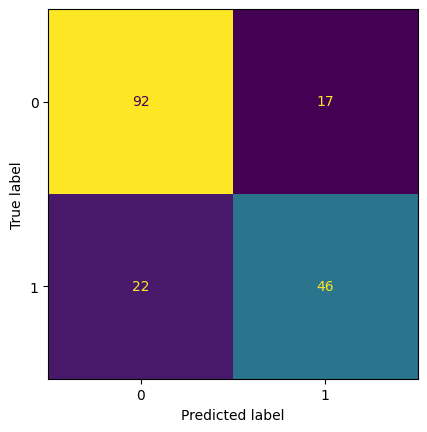

ROC-AUC Score: 0.7602536427415003


In [12]:
print('####### LOGISTIC REGRESSION CLASSIFICATION REPORT #######')
print(classification_report(y_true= yTrain, y_pred= [1 if log_reg_cv[i][1] > 0.5 else 0 for i in range(len(log_reg_cv))]))
ConfusionMatrixDisplay.from_predictions(y_true= yTrain, y_pred= [1 if log_reg_cv[i][1] > 0.5 else 0 for i in range(len(log_reg_cv))], colorbar= False)
plt.show()
print(f'ROC-AUC Score: {roc_auc_score(y_true=yTrain, y_score = [1 if log_reg_cv[i][1] > 0.5 else 0 for i in range(len(log_reg_cv))])}')

####### DECISION TREE CLASSIFICATION REPORT #######
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       109
           1       0.60      0.65      0.62        68

    accuracy                           0.70       177
   macro avg       0.69      0.69      0.69       177
weighted avg       0.71      0.70      0.70       177



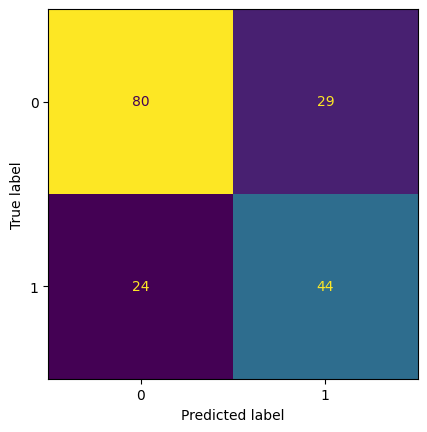

ROC-AUC Score: 0.6905018888289262


In [13]:
print('####### DECISION TREE CLASSIFICATION REPORT #######')
print(classification_report(y_true= yTrain, y_pred= [1 if decisionTree_cv[i][1] > 0.5 else 0 for i in range(len(decisionTree_cv))]))
ConfusionMatrixDisplay.from_predictions(y_true= yTrain, y_pred= [1 if decisionTree_cv[i][1] > 0.5 else 0 for i in range(len(decisionTree_cv))], colorbar= False)
plt.show()
print(f'ROC-AUC Score: {roc_auc_score(y_true=yTrain, y_score = [1 if decisionTree_cv[i][1] > 0.5 else 0 for i in range(len(decisionTree_cv))])}')

####### SUPPORT VECTOR CLASSIFICATION REPORT #######
              precision    recall  f1-score   support

           0       0.63      0.91      0.74       109
           1       0.50      0.15      0.23        68

    accuracy                           0.62       177
   macro avg       0.57      0.53      0.49       177
weighted avg       0.58      0.62      0.55       177



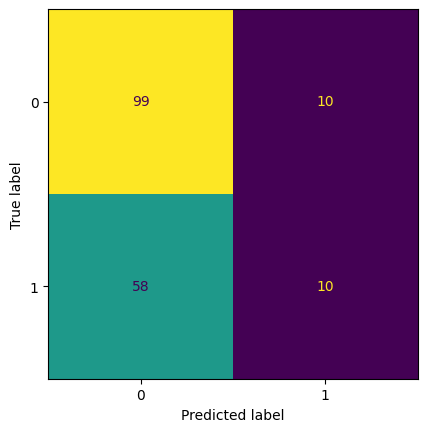

ROC-AUC Score: 0.5276578521316783


In [14]:
print('####### SUPPORT VECTOR CLASSIFICATION REPORT #######')
print(classification_report(y_true= yTrain, y_pred= [1 if svc_cv[i][1] > 0.5 else 0 for i in range(len(svc_cv))]))
ConfusionMatrixDisplay.from_predictions(y_true= yTrain, y_pred= [1 if svc_cv[i][1] > 0.5 else 0 for i in range(len(svc_cv))], colorbar= False)
plt.show()
print(f'ROC-AUC Score: {roc_auc_score(y_true=yTrain, y_score = [1 if svc_cv[i][1] > 0.5 else 0 for i in range(len(svc_cv))])}')

As we can see from the classification reports and confusion matrices, all the models are biased towards the non-survival class. This can be seen in the higher precision, recall, and F1-scores for the class in each model's classification report. The implication is that model predicts non-survival more often because it is the most prominent class. Therefore there are less misclassifications of non-survival since the majority of instances are from the non-survival class. The logicistic regression model performed the best with the highest ROC-AUC and the SVM performed the worst of all the models. However, our data was not scaled when we fit these models. As previously mentioned scaling data can help to prevent features with large scales from overpowering features with smaller scales. Scaling data can also help models that perform lots of computation such as SVMs to converge to better solutions. To examine the effects of using scaled data, let retrain our models with scaled data.

In [15]:
scaler = StandardScaler()
scaler.fit(xTrain)

xTrain_scaled = pd.DataFrame(data= scaler.transform(X= xTrain), columns= xTrain.columns)
xTest_scaled = pd.DataFrame(data= scaler.transform(X= xTest), columns= xTest.columns)

In [16]:
svc = svm.SVC(probability= True)
svc_scaled_cv = cross_val_predict(estimator=svc, X=xTrain_scaled, y=yTrain, cv=5, method='predict_proba')

####### SCALED SUPPORT VECTOR CLASSIFICATION REPORT #######
              precision    recall  f1-score   support

           0       0.76      0.83      0.79       109
           1       0.68      0.57      0.62        68

    accuracy                           0.73       177
   macro avg       0.72      0.70      0.71       177
weighted avg       0.73      0.73      0.73       177



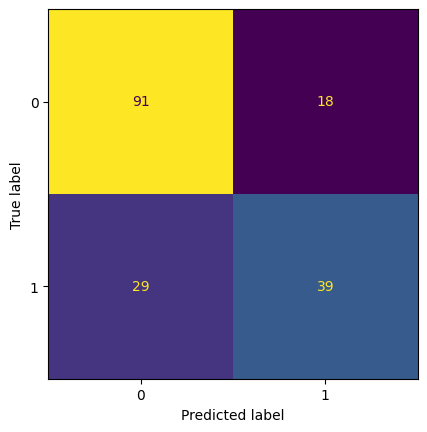

ROC-AUC Score: 0.7041958985429034


In [17]:
print('####### SCALED SUPPORT VECTOR CLASSIFICATION REPORT #######')
print(classification_report(y_true= yTrain, y_pred= [1 if svc_scaled_cv[i][1] > 0.5 else 0 for i in range(len(svc_scaled_cv))]))
ConfusionMatrixDisplay.from_predictions(y_true= yTrain, y_pred= [1 if svc_scaled_cv[i][1] > 0.5 else 0 for i in range(len(svc_scaled_cv))], colorbar= False)
plt.show()
print(f'ROC-AUC Score: {roc_auc_score(y_true=yTrain, y_score = [1 if svc_scaled_cv[i][1] > 0.5 else 0 for i in range(len(svc_scaled_cv))])}')

The support vector classifier using the scaled data performed remarkably better than than model did when using unscaled data. Using the scaled data, the model achieved a precision score of 0.7 compared to the unscaled data which had a score of 0.59. This implies that the scaled data increases the ability of the model to correctly a survivor. Similarly, the recall of the model also improved when using the scaled data. It increased from 0.19 to 0.57 for predicting a survivor. Interestingly, the recall decreased when prediciting deaths from 0.92 to 0.84 when using the scaled data. From this we can say that the scaled data increased the ability of the model to correctly predict true survivors. When using the scaled data the accuracy of the model increased from 0.64 to 0.74, implying that the model does a better job of correctly predicting whether a person survived or died.

####### SCALED LOGISTIC REGRESSION CLASSIFICATION REPORT #######
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       109
           1       0.74      0.71      0.72        68

    accuracy                           0.79       177
   macro avg       0.78      0.77      0.78       177
weighted avg       0.79      0.79      0.79       177



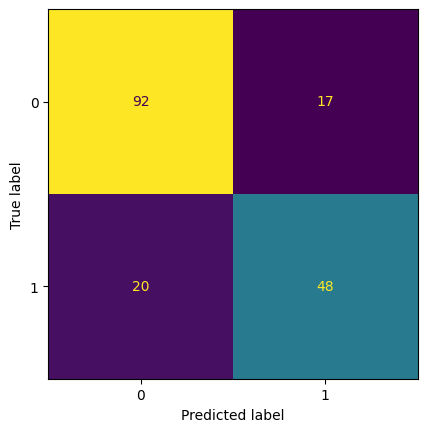

ROC-AUC Score: 0.7749595250944415


In [31]:
lr = LogisticRegression(max_iter= 1000)
lr_scaled = cross_val_predict(log_reg, xTrain_scaled, yTrain,cv=5, method='predict_proba')
print('####### SCALED LOGISTIC REGRESSION CLASSIFICATION REPORT #######')
print(classification_report(y_true= yTrain, y_pred= [1 if lr_scaled[i][1] > 0.5 else 0 for i in range(len(lr_scaled))]))
ConfusionMatrixDisplay.from_predictions(y_true= yTrain, y_pred= [1 if lr_scaled[i][1] > 0.5 else 0 for i in range(len(lr_scaled))], colorbar= False)
plt.show()
print(f'ROC-AUC Score: {roc_auc_score(y_true=yTrain, y_score = [1 if lr_scaled[i][1] > 0.5 else 0 for i in range(len(lr_scaled))])}')

####### SCALED DECISION TREE CLASSIFICATION REPORT #######
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       109
           1       0.60      0.65      0.62        68

    accuracy                           0.70       177
   macro avg       0.69      0.69      0.69       177
weighted avg       0.71      0.70      0.70       177



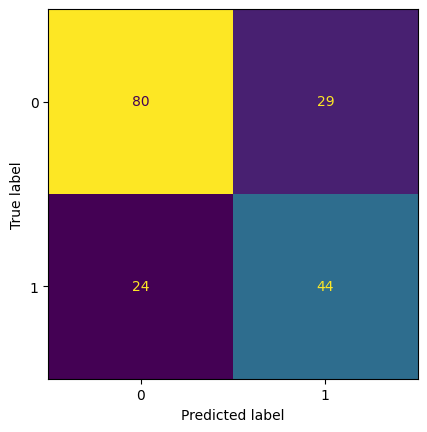

ROC-AUC Score: 0.6905018888289262


In [32]:
dtree = DecisionTreeClassifier()
dtree_scaled = cross_val_predict(estimator=decisionTree, X=xTrain, y=yTrain, cv=5, method='predict_proba')
print('####### SCALED DECISION TREE CLASSIFICATION REPORT #######')
print(classification_report(y_true= yTrain, y_pred= [1 if dtree_scaled[i][1] > 0.5 else 0 for i in range(len(dtree_scaled))]))
ConfusionMatrixDisplay.from_predictions(y_true= yTrain, y_pred= [1 if dtree_scaled[i][1] > 0.5 else 0 for i in range(len(dtree_scaled))], colorbar= False)
plt.show()
print(f'ROC-AUC Score: {roc_auc_score(y_true=yTrain, y_score = [1 if dtree_scaled[i][1] > 0.5 else 0 for i in range(len(dtree_scaled))])}')

As you can see from both the confusion matrices and the ROC-AUC scores, scaling the data improved the performance of both the logicistic regression and the SVM, while the performance of the decision tree was slightly worse. Scaling the data significantly improved the performance of the SVM model, implying that certain model perform best on scaled data while other model such as decision trees are less sensitive to scaled data. To examine the impact of the scaled data and hyperparameter tuning on the SVM model, we will use grid search to tune the hyperparameters of the SVM and fit it using the scaled data.

In [18]:
params = {'kernel':['rbf'], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1], 'C':[1,10,50,100,200,300]}

svc_grid_cv = GridSearchCV(estimator=svc,
                           param_grid=params,
                           cv=5,
                           scoring='roc_auc',
                           verbose=1)

svc_grid_cv.fit(xTrain_scaled, yTrain)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [1, 10, 50, 100, 200, 300],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
                         'kernel': ['rbf']},
             scoring='roc_auc', verbose=1)

In [19]:
print(f'Best parameters: {svc_grid_cv.best_params_}\t Best ROC-AUC Score:{svc_grid_cv.best_score_}')

Best parameters: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}	 Best ROC-AUC Score:0.8366657152371438


Clearly the tuned SVM model had the best performance on the scaled test data with an ROC-AUC score of 0.8367. This far surpasses the performance of the other models fitted with the scaled data. What we are really interested in is how well the model can predict the survival of a passsenger from unseen data. To test the model, we predict the values of the scaled test data and examined the ROC-AUC score and confusion matrix.

####### TUNED SUPPORT VECTOR CLASSIFICATION REPORT #######
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       440
           1       0.74      0.69      0.71       272

    accuracy                           0.79       712
   macro avg       0.78      0.77      0.77       712
weighted avg       0.79      0.79      0.79       712



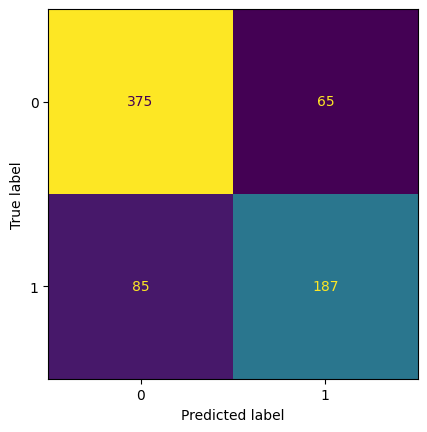

ROC-AUC Score: 0.7698863636363636


In [ ]:
preds = svc_grid_cv.predict(xTest_scaled)
print('####### TUNED SUPPORT VECTOR CLASSIFICATION REPORT #######')
print(classification_report(y_true= yTest, y_pred= preds))
ConfusionMatrixDisplay.from_predictions(y_true= yTest, y_pred= preds, colorbar= False)
plt.show()
print(f'ROC-AUC Score: {roc_auc_score(y_true=yTest, y_score = preds)}')

The model a lower ROC-AUC score on the test data then it did on the training data. This suggests that the model does a worse job of separating classes on unseen data then on the training data. The implication is that the model is overfit to the training data and additional model tuning should be done to help prevent overfitting. Despite overfitting, the model still preforms fairly well an accuracy of 79%. It was most successful with correctly predicting non-survival with an F1-score of 0.83 compared to the 0.69 F1-score for survival. This suggests that the model may be biased toward non-survival. This makes sense as the classes are heavily imbalanced with a greater share of instances in the non-survival class. To improve the performance of the model, different techniques to deal with the class imbalance such as oversampling the underrepsented class or class weights could be implemented. These methods are outside the scope of this exercise.